# WM Error Analysis

## General Info about the WM task:
The category specific representation task and the working memory task are combined into a single task paradigm. Participants were presented with blocks of trials that consisted of pictures of places, tools, faces and body parts (non-mutilated parts of bodies with no “nudity”). Within each run, the 4 different stimulus types were presented in separate blocks. Also, within each run, ½ of the blocks use a 2-back working memory task and ½ use a 0-back working memory task (as a working memory comparison). A 2.5 second cue indicates the task type (and target for 0-back) at the start of the block. Each of the two runs contains 8 task blocks (10 trials of 2.5 seconds each, for 25 seconds) and 4 fixation blocks (15 seconds). On each trial, the stimulus is presented for 2 seconds, followed by a 500 ms inter-task interval (ITI). 

## Research goal
See if there's a relationship between rest-vs.-wm classifier performance and wm behavior. We predict that WM trials that are misclassified as rest are more likely to have incorrect behavior.
An additional question to look at: With the 2-back task, do WM trials misclassified as rest have incorrect behavior on t0 or t0-2?

For each subject, create a dataframe that has resting state data and WM data.
The dataframe should have columns that indicate the trial number that each sample belongs to (only applicable for WM task, can be 0 for all rest samples), and whether that trial was correct or incorrect (only applicable for WM task, can be 0 for all rest samples)

## To do

- Count how many samples belong to incorrect trials that were misclassified as rest.
- Count how many samples belong to correct trials that were misclassified as rest.
- come up with a boredom index model.
- Make figures and slides to go with research narrative 
- Analyze the boredom classifier results.
- Possibly re run classifier but take out all the non-task frames from WM before subsamping the rest data
- Re run classifier with smaller set of feature dimensions as transformed by PCA
- Make visualizations of co-occurrance of incorrect classifications with incorrect behavior


## Done
- Sanity check 1.0:   Logistic refression doesn't work to classify task.
- Sanity check 1.1:   We can classify task state with high accuracy using KNN classifier.
- Sanity check 1.2:   We compared the performance of different classifiers to make sure that KNN was a good choice. This analysis was done on the 2 leading principle components of the 360 parcel data, so it could be visualized. RBF SVM is also a good choice.
- Sanity check 1.2.1: We can see that the number of PCs needed to reach peak classification accuracy is about 50-75.
- Modified HCP_csv_making notebook so that it saves out CSV files for boredom analysis. These are individual subject dataframes that have columns for run, frame number, trial number, condition, response_correct, classifier_correct, classifier_predict_prob etc.
- Produced new dataframes that include the KNN classification results.

## Imports

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import decomposition
from sklearn.metrics import plot_confusion_matrix
import pandas as pd
from IPython.display import clear_output
import seaborn as sns



## Run KNN on all boredom data and update boredom dataframes (and CSV files) with classifier results for each sample

In [58]:
subjects = range(339)

for subj in subjects:

    # Load in boredom csv
    df = pd.read_csv('%i_boredom_df.csv'%subj, index_col=0)
    
    # Take out the non-trial frames from the WM task subset
#     df = df[df.condition==0 & df.task_name=='wm']
    df = df[(df.condition!='0') | (df.task_name!='wm')]

    # Equalize number of trials between the two task states, i.e., randomly sample len(wm_task) frames of resting state data.
    num_trials = []
    for task_num_ind in np.unique(df.task_num):
        num_trials.append(df[df['task_num']==task_num_ind].shape[0])

    df_sub = df.iloc[0:1,:] # initialize a 1-row dataframe for concatenation

    for task_num_ind in np.unique(df.task_num):
        df_temp = df[df['task_num']==task_num_ind].sample(min(num_trials),axis=0)
        df_sub = pd.concat((df_sub, df_temp),axis=0)

    df_sub = df_sub.iloc[1:] # remove the initialized row

    # Identify original features and labels
    X = df_sub.loc[:,'R_V1':'L_p24']
    y = df_sub.loc[:,'task_num']

    # Split the data into test and train sets
    X = StandardScaler().fit_transform(X) # standardize features by removing mean and scaling to unit variance
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

    # Run the KNN classifier on the data
    clf = KNeighborsClassifier(10)
    clf.fit(X_train, y_train)

    # Get prediction probabilities for all X data
    prediction_probabilities = clf.predict_proba(X)

    # Update dataframe columns with prediction probabilites
    df_sub['predict_prob_rest'] = prediction_probabilities[:,0]
    df_sub['predict_prob_WM'] = prediction_probabilities[:,1]
    df_sub['classifier_prediction'] = clf.predict(X)
    df_sub['classifier_correct'] = np.abs(clf.predict(X) - y)*-1+1

    # Save out new dataframe
    df_sub = df_sub.sort_index()
    df_sub.to_csv('%i_boredom_analysis_df.csv'%subj)



/Users/slnoah/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (5,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/slnoah/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (5,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/slnoah/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (5,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/slnoah/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (5,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = awa

## Visualize relationship between classifier_prediction and correct_or_not

In [59]:
# Initialize seaborn
sns.set()

# Initialize big dataframe
columns = df_sub.columns
big_df = pd.DataFrame(columns=columns)

# Load in all subjects to make a big dataframe
for subj in subjects:
    df_subj = pd.read_csv('%i_boredom_analysis_df.csv'%subj, index_col=0)
    big_df = big_df.append(df_subj, ignore_index=True)


In [60]:
big_df.shape

(391952, 373)

In [63]:
# Subset to just WM 
df_wm = big_df[big_df.task_name=='wm']
df_wm.shape

(195976, 373)

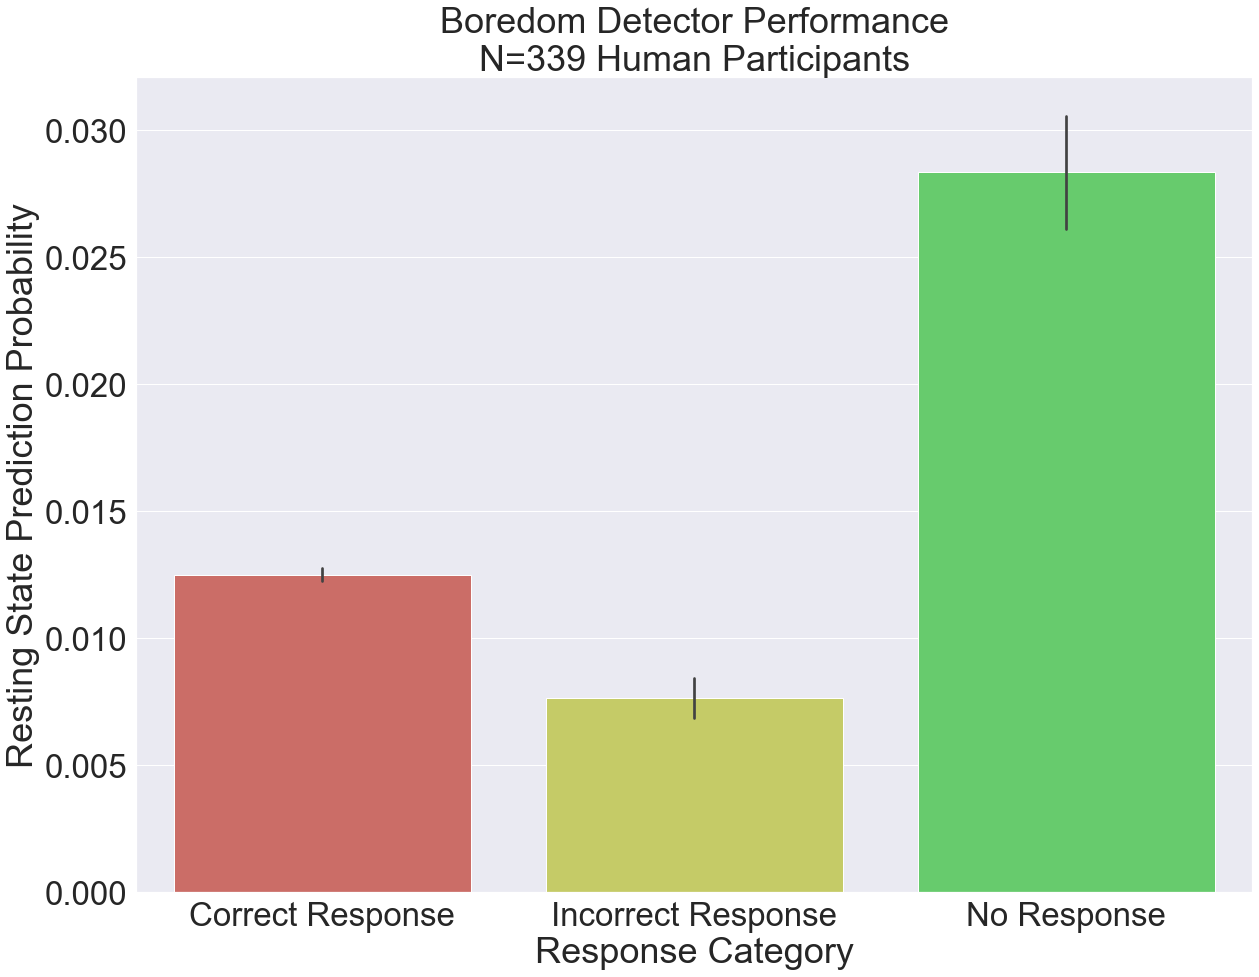

In [190]:
# Show the joint distribution using kernel density estimation
df_wm.loc[df_wm.correct_or_not=='nlr','correct_or_not'] = 'No Response'
df_wm.loc[df_wm.correct_or_not=='cor','correct_or_not'] = 'Correct Response'
df_wm.loc[df_wm.correct_or_not=='err','correct_or_not'] = 'Incorrect Response'

sns.set(font_scale=3)
sns.set_palette("hls")
fig_dims = (20, 15)
fig, ax = plt.subplots(figsize=fig_dims)
# ax = sns.barplot(x="correct_or_not", y="predict_prob_rest", data=df_wm.loc[df_wm.predict_prob_rest>0] )
ax = sns.barplot(x="correct_or_not", y="predict_prob_rest", data=df_wm)
ax.set_title('Boredom Detector Performance\nN=339 Human Participants')
ax.set_xlabel('Response Category')
ax.set_ylabel('Resting State Prediction Probability')
fig = ax.get_figure()
fig.savefig("boredom_detector.png")

In [ ]:
df_wm.columns

(0.0, 1.0)

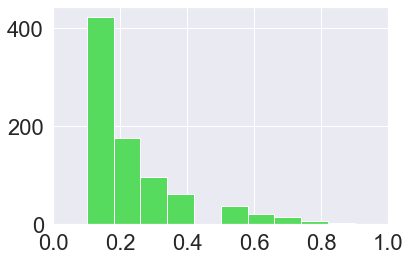

In [187]:
df_nathan = big_df.loc[(big_df.correct_or_not=='nlr') & (big_df.predict_prob_rest>0)]
# df_nathan = big_df.loc[(big_df.correct_or_not=='nlr') & (big_df.predict_prob_rest>=0)]
plt.hist(df_nathan.predict_prob_rest,color=sns.hls_palette()[2])
plt.xlim([0, 1])
